# Problem Description

- The competition is called : **Corporacion Favorita Grocery Sales Forecasting**.
- The task is to predict sales in the stores of an Ecuadorian supermarket chain so that they can avoid overstocking.
- The given data is a table with the following variables/features: date, store id, item id, sales volume, promotion.
- We can see the data as N time series, one per (store, item) combination. Many of these time series are most likely correlated to each other and some sort of <b>dimensional reduction</b> will be most welcome here. 
- The company also offers some other data sets, such as a list of stores, a time series of daily transactions per store, a list of holidays and events, a list of products by category, and the price of oil, of which a good chunk of the ecuadorian economy is allegedly tied to. These are additional tools to simplify and/or enhance the predictions, and some other external data could also be used in this regard. 

# Set-up

In [ ]:
# DATA MANIPULATION
import numpy as np # linear algebra
import random as rd
import pandas as pd # data processing
import datetime # manipulating date formats
from operator import add # elementwise addition

# VIZUALIZATION
import matplotlib.pyplot as plt # basic plotting
import seaborn # for prettier plots
#import folium # plotting data on interactive maps
%matplotlib inline

In [ ]:
# Reading daily transfers per store
sales = pd.read_csv('../input/transactions.csv', parse_dates=['date'])

# Reading store list
stores = pd.read_csv('../input/stores.csv')
stores.type=stores.type.astype('category')

# Reading the holiday and events schedule
holidays=pd.read_csv('../input/holidays_events.csv', parse_dates=['date'])

# Reading oil
oil=pd.read_csv('../input/processed/oil.csv', parse_dates=['date'])

# Merge datasets
sales=pd.merge(sales,stores,how='left')
sales=pd.merge(sales,oil,how='left')

# Feature engineering

### Date

First, let's work on creating features derived from the date, which is expected to be an important field as we are working with time series

In [ ]:
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day
sales['week'] = sales['date'].dt.week
sales['dow'] = sales['date'].dt.dayofweek
sales['dayofyear'] = sales['date'].dt.dayofyear
sales['dayoff']=[x in [5,6] for x in sales.dow] ## Weekends

#sales[sales.dow==6].head()

### Holiday events
This events are expected to be correlated with high volume sales

In [4]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
# Enable all holidays
for (d,t,l,n) in zip(holidays.date,holidays.type,holidays.locale,holidays.locale_name):
    if t!='Work Day' and t!='Event':  
        if l=='National':
            sales.loc[sales.date==d,'dayoff']=True
        elif l=='Regional':
            sales.loc[(sales.date==d)&(sales.state==n),'dayoff']=True
        else:
            sales.loc[(sales.date==d)&(sales.city==n),'dayoff']=True
    else:
        sales.loc[(sales.date==d),'dayoff']=False


In [6]:
## Some manual verifications
sales.loc[lambda df: df.date=='2015-01-10'].head()
#sales.loc[lambda df: (df.date=='2017-04-13') & (df.city=='Cuenca')].head()
#sales.loc[lambda df: (df.date=='2013-04-01') & (df.state=='Cotopaxi')].head()

,date,store_nbr,transactions,city,state,type,cluster,dcoilwtico,year,month,day,week,dow,dayofyear,dayoff
34431,2015-01-10,1,1534,Quito,Pichincha,D,13,47.587,2015,1,10,2,5,10,False
34432,2015-01-10,2,2083,Quito,Pichincha,D,13,47.587,2015,1,10,2,5,10,False
34433,2015-01-10,3,3601,Quito,Pichincha,D,8,47.587,2015,1,10,2,5,10,False
34434,2015-01-10,4,1689,Quito,Pichincha,D,9,47.587,2015,1,10,2,5,10,False
34435,2015-01-10,5,1645,Santo Domingo,Santo Domingo de los Tsachilas,D,4,47.587,2015,1,10,2,5,10,False


### Transactions


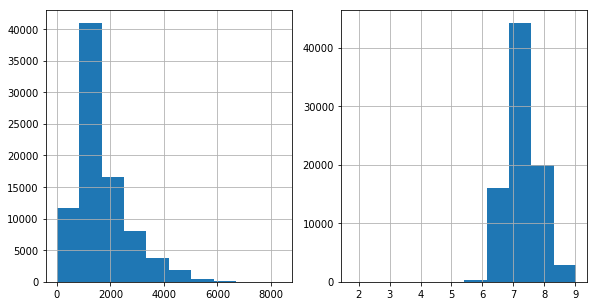

In [7]:
# Transformation
sales['transactions2'] = np.log1p(sales.transactions)

# Normalized
#sales['transactions3'] = (sales['transactions2'] - sales['transactions2'].mean()) / sales['transactions2'].std()
# Normalize independently 

# Histograms
plt.figure(figsize=(15,5))
sales.transactions.hist(ax=plt.subplot(1,3,1))
sales.transactions2.hist(ax=plt.subplot(1,3,2))
#sales.transactions3.hist(ax=plt.subplot(1,3,3))

In [8]:
# Denormalize
def denormalize_target(sales, target, transform=False):
    target_std = sales['transactions2'].std()
    target_mean = sales['transactions2'].mean()

    out = target * target_std + target_mean
    if transform:
        out = np.expm1(out)
    
    return out
    
#test = denormalize_target(sales, sales.transactions3, True)
#test.hist()

Both distributions are skewed. But the transformed looks more normal

### Categorical features

Use one-hot encoding for city, state, type.
This might create hundreds of features, which could be restricting given the amount of data.

In [9]:
cat_columns = ['store_nbr','city', 'state', 'type']

def encode(df, column) -> pd.DataFrame:
    one_hot = pd.get_dummies(df[column], drop_first=False, prefix=column)
    #return (one_hot - one_hot.mean()) / one_hot.std()
    return one_hot

for column in cat_columns:
    column_enc = encode(sales, column)
    sales = pd.concat([sales,column_enc], axis=1)

#sales.drop([c for c in cat_columns if c!='store_nbr'], axis=1, inplace=True)

In [10]:
#sales.info()
#[c for c in sales.columns]

['date',
 'store_nbr',
 'transactions',
 'city',
 'state',
 'type',
 'cluster',
 'dcoilwtico',
 'year',
 'month',
 'day',
 'week',
 'dow',
 'dayofyear',
 'dayoff',
 'transactions2',
 'store_nbr_1',
 'store_nbr_2',
 'store_nbr_3',
 'store_nbr_4',
 'store_nbr_5',
 'store_nbr_6',
 'store_nbr_7',
 'store_nbr_8',
 'store_nbr_9',
 'store_nbr_10',
 'store_nbr_11',
 'store_nbr_12',
 'store_nbr_13',
 'store_nbr_14',
 'store_nbr_15',
 'store_nbr_16',
 'store_nbr_17',
 'store_nbr_18',
 'store_nbr_19',
 'store_nbr_20',
 'store_nbr_21',
 'store_nbr_22',
 'store_nbr_23',
 'store_nbr_24',
 'store_nbr_25',
 'store_nbr_26',
 'store_nbr_27',
 'store_nbr_28',
 'store_nbr_29',
 'store_nbr_30',
 'store_nbr_31',
 'store_nbr_32',
 'store_nbr_33',
 'store_nbr_34',
 'store_nbr_35',
 'store_nbr_36',
 'store_nbr_37',
 'store_nbr_38',
 'store_nbr_39',
 'store_nbr_40',
 'store_nbr_41',
 'store_nbr_42',
 'store_nbr_43',
 'store_nbr_44',
 'store_nbr_45',
 'store_nbr_46',
 'store_nbr_47',
 'store_nbr_48',
 'store_nbr

In [56]:
print_cols = [c for c in sales.columns if 
             not c.startswith('store_nbr_') and 
             not c.startswith('city_') and 
             not c.startswith('state') and 
             not c.startswith('type_')]

### Check the missing data

This is necessary in this point, because in the next step a lot of rows will be injected to provide complete time series.

In [11]:
md = [(c,sales[c].isnull().sum()) for c in sales.columns]

for a in md:
    if a[1]>0:
        print(a)

There is no missing data

### Lagged features: lag_7 (weekly trend)

In [13]:
## Fill missing rows using a product between the stores and the dates (range min-max)

#u_dates = sales.date.unique() # There are no records for some dates (eg: 25-dic)
dates_range =  pd.date_range(sales.date.min(), sales.date.max())
u_stores = sales.store_nbr.unique()

sales2 = sales.copy()
sales2.set_index(["date", "store_nbr"], inplace=True)
sales2 = sales2.reindex(
    pd.MultiIndex.from_product(
        [dates_range, u_stores],
        names=["date", "store_nbr"]
    )
)
sales2.sort_index(inplace=True)
#some_cols2 = [c for c in some_cols if c!='date' and c!='store_nbr']

In [62]:
sales2['lag_7']=np.nan
sales2['lag_7']=sales2['transactions2'].shift(7*len(u_stores))

sales2[['transactions2','lag_7']].corr()

NameError: name 'sales2' is not defined

### Lagged features: lag_365 (anual trend)

In [33]:
sales2['lag_annual']=np.nan
sales2['lag_annual']= sales2['transactions2'].shift(364*len(u_stores)).values

#sales2['lag_annual']= \
#    (1 *   sales2['transactions2'].shift(364*len(u_stores)).values + 
#     1.5 * sales2['transactions2'].shift(365*len(u_stores)).values + 
#     1 *sales2['transactions2'].shift(366*len(u_stores)).values)/3.5
# It was not better than (364 shift)

sales2[['transactions2','lag_annual']].corr()

,transactions2,lag_annual
transactions2,1.000000,0.961503
lag_annual,0.961503,1.000000


Why using a simple shift of 364 provides a better R2 metric???

In [34]:
# Delete temporal df
sales = sales2.reset_index()
del sales2

### Check missing data in the lag features

In [ ]:
sales[(sales.lag_7.isnull()) & 
      (sales.transactions.notnull()) & 
      (sales.date>='2015-01-01') &
      (sales.dayofyear != 1) &
      (sales.dayofyear != 8) &
      (sales.store_nbr != 20) &
      (sales.store_nbr != 21) &
      (sales.store_nbr != 22) &
      (sales.store_nbr != 29) &
      (sales.store_nbr != 42) &
      (sales.store_nbr != 52) &
      (sales.store_nbr != 53) 
     ][print_cols].head(10)

Observaciones:
- No existe registros para el 25-dic. Esto puede ser debido a que no trabajan en esa fecha 
- Some stores have a late start / short life

# EDA

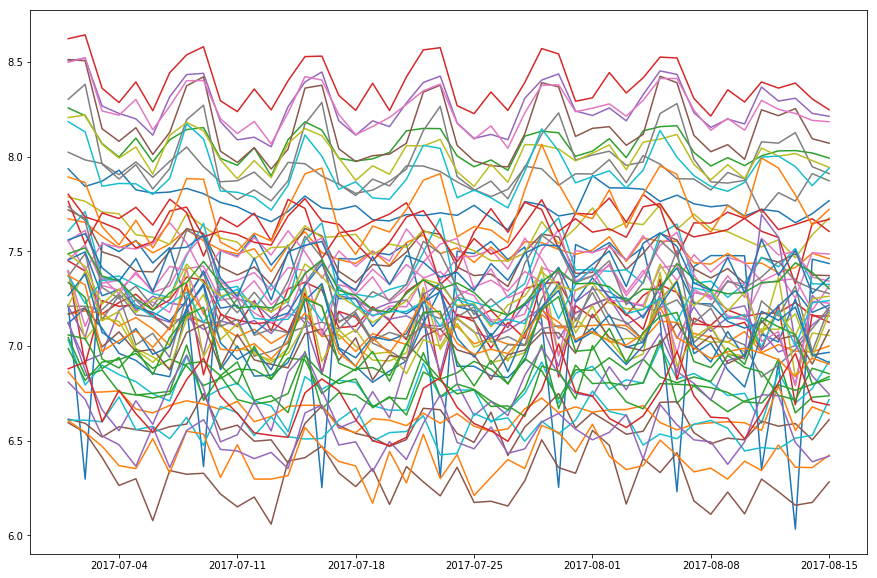

In [36]:
plt.figure(figsize=(15,10))

for store in sorted(sales.store_nbr.unique()):
    a_store = sales[(sales.store_nbr==store) & (sales.date>='2017-07-01')]
    ts = pd.Series(a_store['transactions2'].values, index = a_store.date)
    plt.plot(ts, label='Store %s'%(store))
    
plt.show()

# Prediction



### Reduce data 

In [ ]:
from_date = '2016-01-01'
sales = sales.loc[(sales.date<'2017-08-01') & (sales.date>=from_date)]

In [ ]:
[(c,sales[c].isnull().sum()) for c in sales.columns]

In [ ]:
sales[ (sales.lag_7.isnull()) & (sales.transactions.notnull()) ].head()

### Drop nan

In [ ]:
print('Dropping nan rows...')
print("Before: ", sales.shape)
sales.dropna(inplace=True)
print("After: ", sales.shape)

### Sorting data

In [ ]:
sales.sort_values(['store_nbr', 'date'], ascending=[True, True], inplace=True)
sales.index=range(sales.shape[0])
sales = sales.reindex()
#sales.head()

### Splitting data

In [ ]:
#sales['prediction'] = None

X1 = sales.loc[(sales.date<'2017-08-01') & (sales.date>='2016-01-01')]
X2  = sales.loc[sales.date>='2017-08-01'].copy()

target_column = 'transactions2' 
y1 = X1[target_column].values
y2 = X2[target_column].values

### MLP

In [ ]:
from sklearn import metrics

np.random.seed(1122)

cols = [c for c in X1 if c not in ['date','store_nbr','type','city','state',
                                   'transactions','transactions2','transactions3',
                                   'prediction']]

number_regressors_to_test = 3
for method in range(1, number_regressors_to_test+1):
    print('\nmethod = ', method)
    
    if (method==1):
        print('Multilayer perceptron (MLP) neural network 01')
        str_method = 'MLP model01'    
        r = MLPRegressor(hidden_layer_sizes=(3,), max_iter=100)
    if (method==2):
        print('Bagging Regressor 01')
        str_method = 'BaggingRegressor01'
        r = BaggingRegressor(DecisionTreeRegressor(max_depth=6,max_features=0.85))        

    if (method==3):
        np.random.seed(1122)
        print('GradientBoosting 01')
        str_method = 'GradientBoosting01'
        r = GradientBoostingRegressor(n_estimators=85, max_depth=6, learning_rate = 0.01, 
                                       verbose=0, warm_start=True,
                                       subsample= 0.87, max_features = 0.8)        

    r.fit(X1[cols], y1)
    yh2 = r.predict(X2[cols])
    X2['prediction_%d'%method] = yh2
    m = metrics.mean_squared_error(y2, yh2)**0.5

    print("Error: %f" % (m))

In [ ]:
X2.head()

In [ ]:
ts  = pd.Series(X2[target_column].values)

plt.figure(figsize=(15,10))
plt.plot(ts, label='Observations')

for c in [c for c in X2.columns if c.startswith("prediction_")]:
    ts_p = pd.Series(X2[c].values)
    plt.plot(ts_p,label=c)

plt.legend()

In [ ]:
import random
random_stores =  sorted(u_stores[random.sample(range(len(u_stores)), 9) ])

plt.figure(figsize=(15,15))

for i in range(len(random_stores)):
    ax1 = plt.subplot(3,3,i+1)
    a_store = X2[X2.store_nbr==random_stores[i]]
    ts = pd.Series(a_store[target_column].values) # , index = a_store.date
    ax1.plot(ts, label='Observations')
    
    for c in [c for c in X2.columns if c.startswith("prediction_")]:
        ts_p = pd.Series(a_store[c].values) # , index = a_store.date
        ax1.plot(ts_p,label=c)

    plt.title('Store {}'.format(random_stores[i]))

plt.legend()

# Conclusions

Some experiments regarding categorical feature encoding showed that:
- One-hot encoding works better than preprocessing.LabelEncoder()

The sequentially resulting RMSEs for the method 1 (MLP) were:
- Label encoding: 0.517800
- One-hot encoding: 0.247412
- Lag-7 & Lag-annual: 0.135791
- Oil price: 0.110811

Normalizing the target variable leads to poor performance. It shall be further analyzed. Maybe it has to do with something that is mentioned in a previous [1st place solution](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md):
"This scale information is lost in a pageviews feature, because each pageviews series independently normalized to zero mean and unit variance"

Among the regressors tested, Bagging Regressor 01 (RMSE 0.105016) seems to be the best

# Build dataset

In [ ]:
#[c for c in sales.columns]
sales.to_csv('../input/processed/sales+.csv', index=False)